# Computer Vision and Image Manipulation Interview Questions

## Theoretical Questions

1. **Explain the difference between object detection and image classification.**

   - **Image classification** involves assigning a single label to an entire image, identifying what object or scene is present. It doesn't provide information on the position of objects within the image.
   - **Object detection**, on the other hand, not only classifies objects within the image but also identifies where they are by predicting bounding boxes around each detected object. Object detection thus handles both localization and classification of multiple objects in an image, making it a more complex task than classification.

2. **What is transfer learning, and how can it be useful in object detection tasks?**

   Transfer learning is a machine learning technique where a model trained on one task is reused as the starting point for a model on a different task. In the context of object detection, transfer learning can be especially useful because models pre-trained on large datasets like ImageNet have already learned rich feature representations (such as edges, shapes, textures). These features can be transferred to an object detection model to improve performance, reduce training time, and achieve better results even with smaller datasets.

3. **Describe the architecture of YOLO (You Only Look Once) and its advantages in real-time object detection.**

   YOLO (You Only Look Once) divides an image into a grid and predicts bounding boxes and probabilities for each grid cell. It treats object detection as a single regression problem, rather than breaking it into separate stages like region proposal and classification. YOLO directly predicts bounding boxes and their associated class probabilities in one go, which makes it extremely fast.

   **Advantages** of YOLO include:
   - **Speed**: YOLO is designed for real-time object detection, capable of processing frames at high FPS (Frames Per Second).
   - **Single-stage architecture**: YOLO simplifies the detection pipeline by performing detection in a single stage, reducing complexity compared to models like Faster R-CNN.
   - **Global reasoning**: YOLO looks at the entire image during detection, leading to fewer false positives in background regions.

4. **What is a Generative Adversarial Network (GAN), and how could it be used in image manipulation tasks?**

   A Generative Adversarial Network (GAN) consists of two neural networks: a **generator** and a **discriminator**. The generator creates synthetic data (e.g., images), while the discriminator tries to distinguish between real data and the synthetic data generated. These two networks compete with each other, leading to the generator improving its ability to create more realistic images over time.

   In **image manipulation tasks**, GANs can be used to generate new images, enhance image resolution, or apply transformations like style transfer, where the style of one image is applied to the content of another. GANs can also be used to fill missing parts of images (inpainting) or even change specific attributes of images, such as altering facial expressions or clothing in photos.

## Coding Challenges

### Challenge 1: Object Detection

#### Install dependencies

In [ ]:
!pip install ultralytics==8.2.100
!pip install pillow==10.4.0
!pip install gradio==4.44.0

#### get enviroment details

In [ ]:
import pkg_resources

# Lista de librerías a verificar
libraries = [
    "torch",
    "pillow",
    "matplotlib",
    "numpy",
    "opencv-python",
    "torchvision",
    "pandas",
    "gradio",
    "ultralytics",
    "torchvision",

]

# Función para obtener la versión de una librería
def get_library_version(library_name):
    try:
        version = pkg_resources.get_distribution(library_name).version
        return f"{library_name}=={version}"
    except pkg_resources.DistributionNotFound:
        return f"{library_name}: No está instalada"

# Imprimir las versiones de las librerías
for lib in libraries:
    print(get_library_version(lib))



torch==2.4.1+cu121
pillow==10.4.0
matplotlib==3.7.1
numpy==1.26.4
opencv-python==4.10.0.84
torchvision==0.19.1+cu121
pandas==2.1.4
gradio==4.44.0
ultralytics==8.2.100
torchvision==0.19.1+cu121


#### Loading the detection model

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision.models as models
import torchvision.transforms as transforms
import pandas as pd
from typing import Optional, Tuple, List, Union
import gradio as gr

%matplotlib inline

# Image paths
cat_image_path = '/content/gato.PNG'     # Path to the cat image
dog_image_path = '/content/perro.PNG'  # Path to the dog image

# Loading the model yolov5 for cat detection
detection_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-24 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


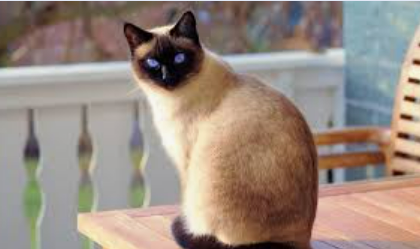

In [ ]:
# Load cat image
cat_img = Image.open(cat_image_path).convert("RGB")
cat_img

#### Cat detection

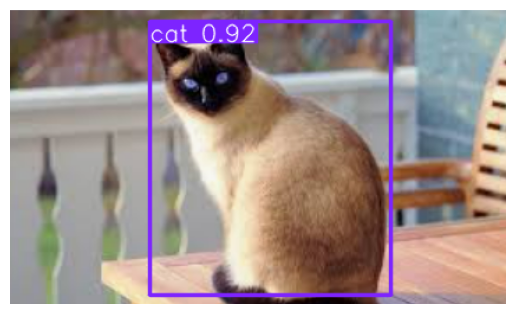

In [ ]:
# Define the COCO class ID for 'cat' as a constant
CAT_CLASS_ID = 15

def detect_cat(image: np.ndarray) -> Optional[Tuple[List[int], Image.Image]]:
    """
    Detects cats in the provided image using the detection_model.

    Args:
        image (np.ndarray): The input image as a NumPy array with shape (H, W, C).

    Returns:
        Optional[Tuple[List[int], PIL.Image.Image]]:
            - bbox (List[int]): Bounding box coordinates [xmin, ymin, xmax, ymax] of the first detected cat.
            - img_with_cats (PIL.Image.Image): Image with bounding boxes drawn around detected cats.
        Returns None if no cats are detected.
    """
    # Perform detection on the image
    results = detection_model(image)

    # Convert the results to a pandas DataFrame
    df_results = results.pandas().xyxy[0]

    # Filter detections for the 'cat' class
    cat_detections = df_results[df_results['class'] == CAT_CLASS_ID]

    if cat_detections.empty:
        print("No cat detected in the image.")
        return None
    else:
        # Get the first cat detection
        first_cat = cat_detections.iloc[0]
        bbox = [
            int(first_cat['xmin']),
            int(first_cat['ymin']),
            int(first_cat['xmax']),
            int(first_cat['ymax'])
        ]

    # Retain only cat detections in the results
    results.xyxy[0] = results.xyxy[0][results.xyxy[0][:, 5] == CAT_CLASS_ID]

    # Render the image with only the cat bounding boxes
    cat_img_with_boxes = results.render()[0]  # Render returns a list of images

    # Convert the NumPy array to a PIL image
    img_with_cats = Image.fromarray(cat_img_with_boxes)

    return bbox, img_with_cats

# Example usage
bbox, img_with_cats = detect_cat(cat_img)

if img_with_cats:
    # Display the final image
    plt.imshow(np.array(img_with_cats))
    plt.axis('off')
    plt.show()


### Challenge 2: Image Manipulation

#### Dog inpainting pipeline

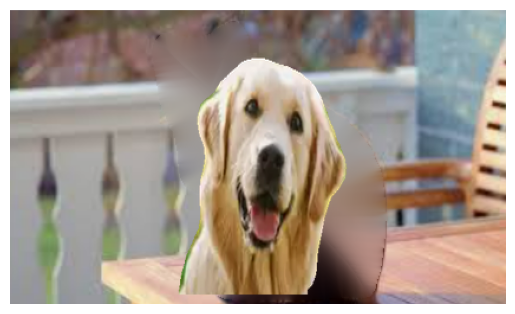

In [ ]:
# Constants
COCO_CAT_CLASS_ID = 17  # COCO class ID for 'cat'
PASCAL_VOC_DOG_CLASS_ID = 12  # PASCAL VOC class ID for 'dog'

def segment_cat(image: Image.Image, bbox: List[int]) -> Optional[np.ndarray]:
    """
    Segments the cat in the image using a pre-trained Mask R-CNN model.

    Args:
        image (PIL.Image.Image): The input image.
        bbox (List[int]): Bounding box coordinates [x_min, y_min, x_max, y_max].

    Returns:
        Optional[np.ndarray]: Binary mask of the cat if detected, else None.
    """
    x_min, y_min, x_max, y_max = bbox

    # Load pre-trained Mask R-CNN model
    model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    # Preprocess the image
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)

    # Perform segmentation
    with torch.no_grad():
        outputs = model(image_tensor)

    # Get masks and labels
    masks = outputs[0]['masks']
    labels = outputs[0]['labels']

    # Filter masks for 'cat' class
    cat_indices = (labels == COCO_CAT_CLASS_ID).nonzero(as_tuple=True)[0]
    if len(cat_indices) == 0:
        print("Could not segment the cat.")
        return None

    # Combine masks
    cat_masks = masks[cat_indices]
    combined_mask = torch.sum(cat_masks, dim=0)
    binary_mask = (combined_mask.squeeze().numpy() > 0.5).astype(np.uint8) * 255

    return binary_mask

def inpaint_image(image: Image.Image, mask: np.ndarray) -> Image.Image:
    """
    Inpaints the masked area in the image using OpenCV's inpainting.

    Args:
        image (PIL.Image.Image): The input image.
        mask (np.ndarray): Binary mask where non-zero pixels represent areas to inpaint.

    Returns:
        PIL.Image.Image: The inpainted image.
    """
    # Convert PIL image to OpenCV format
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Inpaint the image
    inpainted_image = cv2.inpaint(image_cv, mask, inpaintRadius=41, flags=cv2.INPAINT_TELEA)

    # Convert back to PIL image
    inpainted_image_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)
    result_image = Image.fromarray(inpainted_image_rgb)

    return result_image

def extract_dog(dog_image: Image.Image) -> Optional[Image.Image]:
    """
    Extracts the dog from the image using DeepLabV3 segmentation and creates a transparent image.

    Args:
        dog_image (PIL.Image.Image): The dog input image.

    Returns:
        Optional[PIL.Image.Image]: The dog image with transparency if detected, else None.
    """
    # Load pre-trained DeepLabV3 model
    deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True)
    deeplab.eval()

    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(dog_image).unsqueeze(0)

    # Perform segmentation
    with torch.no_grad():
        output = deeplab(input_tensor)['out'][0]
    output_predictions = output.argmax(0)

    # Create mask for 'dog' class
    dog_mask = (output_predictions == PASCAL_VOC_DOG_CLASS_ID).cpu().numpy()
    if not dog_mask.any():
        print("No dog detected in the image.")
        return None

    # Create transparent image
    dog_mask_uint8 = (dog_mask.astype(np.uint8)) * 255
    image_np = np.array(dog_image)
    alpha_channel = dog_mask_uint8

    # Combine RGB channels with alpha channel
    image_rgba = np.dstack((image_np, alpha_channel))
    dog_image = Image.fromarray(image_rgba, mode='RGBA')

    return dog_image

def replace_cat_with_dog(inpainted_image: Image.Image, dog_image: Image.Image, bbox: List[int]) -> Image.Image:
    """
    Replaces the cat region in the inpainted image with the dog image.

    Args:
        inpainted_image (PIL.Image.Image): The image with the cat removed.
        dog_image (PIL.Image.Image): The dog image with transparency.
        bbox (List[int]): Bounding box coordinates [x_min, y_min, x_max, y_max].

    Returns:
        PIL.Image.Image: The final image with the dog replacing the cat.
    """
    x_min, y_min, x_max, y_max = bbox

    # Resize the dog image to match the cat's bounding box
    dog_width = x_max - x_min
    dog_height = y_max - y_min
    resized_dog = dog_image.resize((dog_width, dog_height), resample=Image.LANCZOS)

    # Paste the dog onto the inpainted image
    result_image = inpainted_image.copy()
    result_image.paste(resized_dog, (x_min, y_min), resized_dog)

    return result_image


# Cargar la imagen del perro
org_dog_image = Image.open(dog_image_path).convert('RGB')
if org_dog_image is None:
    print("Could not open or find the dog image.")
    exit(1)

# Segment and remove the cat from the image
cat_mask = segment_cat(cat_img, bbox)
if cat_mask is None:
    print("Could not segment the cat.")
    exit(1)

inpainted_image = inpaint_image(cat_img, cat_mask)

# Extract the dog image with transparency
dog_image = extract_dog(org_dog_image)
if dog_image is None:
    print("Could not extract the dog.")
    exit(1)

# Replace the cat with the dog
result_image = replace_cat_with_dog(inpainted_image, dog_image, bbox)

# Display the result
plt.imshow(result_image)
plt.axis('off')
plt.show()


#### Challenge 3: End-to-End Pipeline

In [46]:
def inpaint_cat_in_image(cat_image: Image.Image, dog_image: Image.Image) -> Union[Image.Image, str, Image.Image]:
    """
    Replaces a cat in the given cat image with a dog from the dog image.

    Args:
        cat_image (PIL.Image.Image): The cat image.
        dog_image (PIL.Image.Image): The dog image.

    Returns:
        Union[PIL.Image.Image, str]:
            - The resulting image with the cat replaced by the dog.
            - An error message if the operation fails.
            - Annotated cat image with bounding boxes if needed.
    """
    # Detect the cat and get the bounding box
    bbox, annotated_image = detect_cat(cat_image)
    if bbox is None:
        return "Could not detect the cat."

    # Segment and remove the cat from the image
    cat_mask = segment_cat(cat_image, bbox)
    if cat_mask is None:
        return "Could not segment the cat."

    inpainted_image = inpaint_image(cat_image, cat_mask)

    # Extract the dog image with transparency
    dog_image_transparent = extract_dog(dog_image)
    if dog_image_transparent is None:
        return "Could not extract the dog."

    # Replace the cat with the dog
    result_image = replace_cat_with_dog(inpainted_image, dog_image_transparent, bbox)
    return result_image
def process_images(cat_img, dog_img):
    """
    Process the uploaded cat and dog images to replace the cat with the dog.

    Args:
        cat_img (PIL.Image.Image): Uploaded cat image.
        dog_img (PIL.Image.Image): Uploaded dog image.

    Returns:
        PIL.Image.Image or str: The resulting image or an error message.
    """
    result = inpaint_cat_in_image(cat_img, dog_img)
    return result

# Define Gradio Interface
with gr.Blocks(css="""
    .gradio-container {background-color: #f0f0f0;}
    .title {font-size: 2em; text-align: center; margin-bottom: 20px;}
    .description {font-size: 1.2em; text-align: center; margin-bottom: 30px;}
    .upload-box {margin-bottom: 20px;}
    .output-box {margin-top: 20px;}
""") as demo:
    gr.Markdown("<h1 style='text-align: center;'>🐱➡️🐶 Cat to Dog Replacer</h1>")
    gr.Markdown("<p style='text-align: center;'>Upload a cat image and a dog image to replace the cat with the dog seamlessly.</p>")

    with gr.Row():
        with gr.Column(scale=1):
            cat_input = gr.Image(label="Upload Cat Image", type="pil")
        with gr.Column(scale=1):
            dog_input = gr.Image(label="Upload Dog Image", type="pil")

    replace_button = gr.Button("Replace Cat with Dog", elem_id="replace-button")


    with gr.Row():
        error_message = gr.Textbox(label="Error Message", interactive=False, visible=False)

    def handle_replace(cat_img, dog_img):
      if cat_img is None or dog_img is None:
          return None, "Please upload both a cat image and a dog image.", None
      result = process_images(cat_img, dog_img)
      if isinstance(result, str):
          return None, result, None
      else:
          bbox, annotated_image = detect_cat(cat_img)  # Imagen con caja del gato
          return result, "", annotated_image

    with gr.Row():
      output = gr.Image(label="Resulting Image", interactive=False)
      cat_annotated_output = gr.Image(label="Detected Cat with Bounding Box", interactive=False)

    replace_button.click(fn=handle_replace, inputs=[cat_input, dog_input], outputs=[output, error_message, cat_annotated_output])



    gr.Markdown("<p style='text-align: center; margin-top: 40px;'>© 2024 CatDog Transformer</p>")

# Launch the interface
demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b89d9a3d30b47e07e1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://b89d9a3d30b47e07e1.gradio.live
